### Define Parameters

In [1]:
seq_len = 100
pred_len = 200

batch_size = 256
max_epochs = 50

### Import libraries and dataset

In [2]:
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from tqdm import tqdm

from model import MICN

from weather.dataset import weather_dataset

dataset = weather_dataset(seq_len=seq_len, pred_len=pred_len)

train_set, test_set, valid_set = dataset.split()

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True)

Found files: ['mpi_roof_2023a.csv', 'mpi_roof_2021b.csv', 'mpi_roof_2021a.csv', 'mpi_roof_2020b.csv', 'mpi_roof_2023b.csv', 'mpi_roof_2022a.csv', 'mpi_roof_2020a.csv', 'mpi_roof_2022b.csv']


/home/filippo/Desktop/nn_project/weather/dataset.py:60: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates_df['month'] = dates_df["Date Time"].apply(lambda row:row.month,1)
/home/filippo/Desktop/nn_project/weather/dataset.py:61: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates_df['day'] = dates_df["Date Time"].apply(lambda row:row.day,1)
/home/filippo/Desktop/nn_project/weather/dataset.py:62: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  dates_df['weekday'] = dates_df["Date Time"].apply(lambda row:row.weekday(),1)
/home/filippo/Desktop/nn_project/weather/dataset.py:63: FutureWarning: the

Found a total of 210441 samples.


In [3]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Using device", device)

model = MICN(seq_len, pred_len, device=device)

Using device cuda:0


## Train the model

In [5]:
criterion = nn.MSELoss(reduction='mean')
criterion = criterion.to(device)
optim = torch.optim.Adam(model.parameters(), lr=1e-6)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)

train_losses = []
val_losses = []

patience = 3
epochs_without_improving = 0

best_epoch = -1
best_val_loss = 0

for epoch in range(max_epochs):
    print("Starting epoch", epoch+1)
    model.train()
    losses = []
    for seq_times, sequence, true_times, true in tqdm(train_loader):
        seq_times, sequence, true_times, true = seq_times.to(device), sequence.to(device), true_times.to(device), true.to(device)
        out = model(sequence, seq_times, true_times)
        
        loss = criterion(out, true)
        losses.append(loss.detach().item())

        loss.backward()
        optim.step()
    if epoch % 5 == 0:
        scheduler.step()
    avg_train_loss = np.mean(losses)
    print("Average train loss:", avg_train_loss)
    train_losses.append(avg_train_loss)
    
    model.eval()
    losses = []
    with torch.no_grad():
        for seq_times, sequence, true_times, true in tqdm(valid_loader):
            seq_times, sequence, true_times, true = seq_times.to(device), sequence.to(device), true_times.to(device), true.to(device)
            out = model(sequence, seq_times, true_times)
            
            loss = criterion(out, true)
            losses.append(loss.detach().item())
    avg_val_loss = np.mean(losses)
    print("Average validation loss:", avg_val_loss)
    val_losses.append(avg_val_loss)

    if best_epoch == -1 or avg_val_loss < best_val_loss:
        best_epoch = epoch
        best_val_loss = avg_val_loss
        epochs_without_improving = 0

        save_name = "MICN_" + str(seq_len) + "_" + str(pred_len) + "_" + str(epoch+1) + ".pt"
        torch.save(model.state_dict(), save_name)
    else:
        epochs_without_improving += 1
    
    if epochs_without_improving > patience:
        print("Stopping at epoch", epoch+1)
        print("Best validation loss reached at epoch", best_epoch)
        model.load_state_dict(torch.load(save_name))
        epoch = best_epoch
        break

Starting epoch 1


  0%|          | 0/657 [00:00<?, ?it/s]/home/filippo/anaconda3/envs/nn_project/lib/python3.11/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
100%|█████████▉| 656/657 [00:38<00:00, 17.15it/s]/home/filippo/anaconda3/envs/nn_project/lib/python3.11/site-packages/torch/nn/modules/conv.py:306: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv1d(input, weight, bias, self.stride,
100%|██████████| 657/657 [00:38<00:00, 17.25it/s]


Average train loss: 213419.8449391172


100%|██████████| 82/82 [00:02<00:00, 40.11it/s]


Average validation loss: 167730.75038109755
Starting epoch 2


100%|██████████| 657/657 [00:38<00:00, 17.20it/s]


Average train loss: 187014.3286244292


100%|██████████| 82/82 [00:02<00:00, 40.07it/s]


Average validation loss: 146168.56783536586
Starting epoch 3


100%|██████████| 657/657 [00:38<00:00, 17.26it/s]


Average train loss: 166266.61513032723


100%|██████████| 82/82 [00:02<00:00, 40.22it/s]


Average validation loss: 127985.93330792683
Starting epoch 4


100%|██████████| 657/657 [00:38<00:00, 17.22it/s]


Average train loss: 148732.0844511035


100%|██████████| 82/82 [00:02<00:00, 40.38it/s]


Average validation loss: 112500.21122332317
Starting epoch 5


100%|██████████| 657/657 [00:38<00:00, 17.29it/s]


Average train loss: 133785.54188070775


100%|██████████| 82/82 [00:02<00:00, 40.06it/s]


Average validation loss: 99186.53153582317
Starting epoch 6


100%|██████████| 657/657 [00:38<00:00, 17.25it/s]


Average train loss: 121026.71530156012


100%|██████████| 82/82 [00:02<00:00, 40.06it/s]


Average validation loss: 87662.86766387195
Starting epoch 7


100%|██████████| 657/657 [00:37<00:00, 17.29it/s]


Average train loss: 110523.3311810312


100%|██████████| 82/82 [00:02<00:00, 40.16it/s]


Average validation loss: 78612.31726371951
Starting epoch 8


100%|██████████| 657/657 [00:38<00:00, 17.20it/s]


Average train loss: 101851.80610254947


100%|██████████| 82/82 [00:02<00:00, 40.25it/s]


Average validation loss: 70662.22580030488
Starting epoch 9


100%|██████████| 657/657 [00:35<00:00, 18.52it/s]


Average train loss: 94308.71766790334


100%|██████████| 82/82 [00:02<00:00, 40.69it/s]


Average validation loss: 63672.51133765244
Starting epoch 10


100%|██████████| 657/657 [00:36<00:00, 18.02it/s]


Average train loss: 87687.40494197108


100%|██████████| 82/82 [00:02<00:00, 40.23it/s]


Average validation loss: 57505.37466653963
Starting epoch 11


100%|██████████| 657/657 [00:37<00:00, 17.30it/s]


Average train loss: 81908.48317993722


100%|██████████| 82/82 [00:02<00:00, 40.10it/s]


Average validation loss: 52077.69169207317
Starting epoch 12


100%|██████████| 657/657 [00:37<00:00, 17.41it/s]


Average train loss: 77098.4612763984


100%|██████████| 82/82 [00:02<00:00, 40.23it/s]


Average validation loss: 47747.68507050305
Starting epoch 13


100%|██████████| 657/657 [00:37<00:00, 17.46it/s]


Average train loss: 73107.36508870815


100%|██████████| 82/82 [00:01<00:00, 41.39it/s]


Average validation loss: 43944.83646150915
Starting epoch 14


100%|██████████| 657/657 [00:37<00:00, 17.45it/s]


Average train loss: 69577.35825128424


100%|██████████| 82/82 [00:02<00:00, 40.12it/s]


Average validation loss: 40598.112471417684
Starting epoch 15


100%|██████████| 657/657 [00:38<00:00, 17.10it/s]


Average train loss: 66593.88896023593


100%|██████████| 82/82 [00:01<00:00, 41.60it/s]


Average validation loss: 37704.351800685974
Starting epoch 16


100%|██████████| 657/657 [00:37<00:00, 17.39it/s]


Average train loss: 64092.27286077816


100%|██████████| 82/82 [00:01<00:00, 41.06it/s]


Average validation loss: 35241.41534870427
Starting epoch 17


100%|██████████| 657/657 [00:38<00:00, 17.28it/s]


Average train loss: 62044.094088898404


100%|██████████| 82/82 [00:01<00:00, 41.81it/s]


Average validation loss: 33378.70612614329
Starting epoch 18


100%|██████████| 657/657 [00:37<00:00, 17.53it/s]


Average train loss: 60502.99098054604


100%|██████████| 82/82 [00:01<00:00, 41.60it/s]


Average validation loss: 31823.173589939026
Starting epoch 19


100%|██████████| 657/657 [00:37<00:00, 17.55it/s]


Average train loss: 59234.28727287862


100%|██████████| 82/82 [00:01<00:00, 41.76it/s]


Average validation loss: 30486.634503620426
Starting epoch 20


100%|██████████| 657/657 [00:37<00:00, 17.68it/s]


Average train loss: 58180.0934943398


100%|██████████| 82/82 [00:01<00:00, 41.70it/s]


Average validation loss: 29361.076410060974
Starting epoch 21


100%|██████████| 657/657 [00:37<00:00, 17.70it/s]


Average train loss: 57353.43136415525


100%|██████████| 82/82 [00:02<00:00, 40.85it/s]


Average validation loss: 28464.122975419206
Starting epoch 22


100%|██████████| 657/657 [00:37<00:00, 17.71it/s]


Average train loss: 56751.683932648404


100%|██████████| 82/82 [00:01<00:00, 41.54it/s]


Average validation loss: 27818.208770007623
Starting epoch 23


100%|██████████| 657/657 [00:37<00:00, 17.72it/s]


Average train loss: 56401.73129518645


100%|██████████| 82/82 [00:01<00:00, 41.47it/s]


Average validation loss: 27326.202267530487
Starting epoch 24


100%|██████████| 657/657 [00:37<00:00, 17.58it/s]


Average train loss: 56107.548177083336


100%|██████████| 82/82 [00:01<00:00, 41.61it/s]


Average validation loss: 26997.340558307926
Starting epoch 25


100%|██████████| 657/657 [00:37<00:00, 17.75it/s]


Average train loss: 56017.31241081621


100%|██████████| 82/82 [00:02<00:00, 40.77it/s]


Average validation loss: 26779.86463891006
Starting epoch 26


100%|██████████| 657/657 [00:37<00:00, 17.69it/s]


Average train loss: 55999.25561560597


100%|██████████| 82/82 [00:01<00:00, 41.76it/s]


Average validation loss: 26689.777105564026
Starting epoch 27


100%|██████████| 657/657 [00:37<00:00, 17.74it/s]


Average train loss: 56091.83280417618


100%|██████████| 82/82 [00:01<00:00, 41.81it/s]


Average validation loss: 26680.60997046494
Starting epoch 28


100%|██████████| 657/657 [00:37<00:00, 17.67it/s]


Average train loss: 56245.34662171804


100%|██████████| 82/82 [00:01<00:00, 41.51it/s]


Average validation loss: 26733.48173113567
Starting epoch 29


100%|██████████| 657/657 [00:37<00:00, 17.60it/s]


Average train loss: 56455.075065996


100%|██████████| 82/82 [00:02<00:00, 40.82it/s]


Average validation loss: 26848.08193597561
Starting epoch 30


100%|██████████| 657/657 [00:37<00:00, 17.60it/s]


Average train loss: 56777.51976312786


100%|██████████| 82/82 [00:01<00:00, 41.58it/s]


Average validation loss: 27051.503477515245
Starting epoch 31


100%|██████████| 657/657 [00:37<00:00, 17.60it/s]


Average train loss: 57103.538265791474


100%|██████████| 82/82 [00:01<00:00, 41.74it/s]

Average validation loss: 27335.613447980184
Stopping at epoch 31
Best validation loss reached at epoch 26


### Plot losses

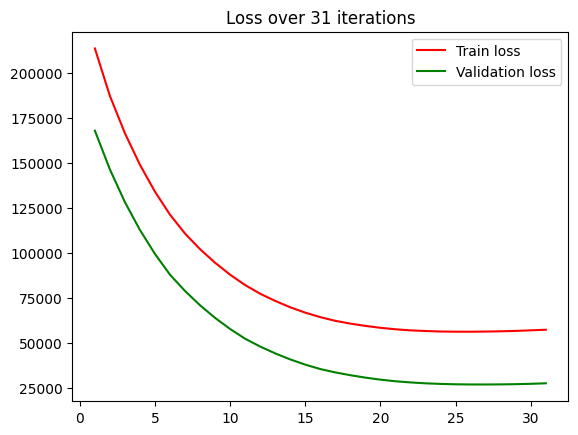

In [6]:
assert len(train_losses) == len(val_losses)
x = [i+1 for i in range(len(train_losses))]
plt.title("Loss over " + str(len(train_losses)) + " iterations")
plt.plot(x, train_losses, color="red", label="Train loss")
plt.plot(x, val_losses, color="green", label="Validation loss")
plt.legend()

plt.show()

## Evaluate on the test set

In [7]:
if 'model' not in locals():
    save_name = "MICN_100_200_27.pt" # if model isn't defined change this line with the model you want to evaluate
    assert int(save_name[5:8]) == seq_len and int(save_name[9:12]) == pred_len
    model = MICN(seq_len, pred_len)
    model.load_state_dict(torch.load(save_name))
if 'device' not in locals():
    device = torch.device("cpu")
    
criterion = nn.MSELoss()
test_losses = []
model.eval()
with torch.no_grad():
    for seq_times, sequence, true_times, true in tqdm(test_loader):
        seq_times, sequence, true_times, true = seq_times.to(device), sequence.to(device), true_times.to(device), true.to(device)
        out = model(sequence, seq_times, true_times)
            
        loss = criterion(out, true)
        test_losses.append(loss.detach().item())
print("Average test loss:", np.mean(test_losses))
print("Average test loss per time step:", np.mean(test_losses)/pred_len)

100%|██████████| 81/81 [00:01<00:00, 41.99it/s]

Average test loss: 70314.9067804784
Average test loss per time step: 351.574533902392


### Example of comparison between true and predicted values

In [12]:
for seq_times, sequence, true_times, true in test_loader:
    seq_times, sequence, true_times, true = seq_times.to(device), sequence.to(device), true_times.to(device), true.to(device)
    out = model(sequence, seq_times, true_times).detach()[0]
    print("avg loss per single time step", criterion(out, true[0]).item()/pred_len)
    print("Predicted True")
    for i in range(pred_len):
        print(out[i][1].cpu().numpy(), true[0][i][1].cpu().numpy())
    break

avg loss per single time step 179.47095703125
Predicted True
9.428913 6.6
8.734521 6.89
12.489103 7.41
8.212005 7.67
7.1222434 8.01
13.717768 8.28
9.698512 8.58
12.354833 8.9
16.608423 9.28
12.052513 9.57
9.126389 9.95
13.532626 10.2
14.998368 10.44
15.584295 10.6
5.7335777 10.74
13.267134 11.05
12.151525 11.22
8.904237 11.52
15.072044 11.8
11.588093 11.87
15.043135 12.01
11.805836 12.13
12.434173 12.22
11.068117 12.2
10.882085 12.35
9.897801 12.41
5.919553 12.4
11.37339 12.43
10.863243 12.62
9.978371 12.83
11.698429 12.72
10.992685 12.65
18.106993 12.62
13.979617 12.8
12.492457 12.92
12.103337 12.74
13.150994 12.81
12.413799 12.8
8.734615 12.78
6.081048 12.78
17.49723 12.85
7.0521164 12.67
11.510727 12.53
14.091053 12.52
14.544205 12.39
11.010211 12.27
11.400431 12.21
14.25971 12.17
13.5329895 12.02
11.926586 11.86
15.063734 11.73
15.975485 11.51
12.732637 11.3
15.297227 11.09
1.0439773 10.78
14.356999 10.5
15.20216 10.34
19.833426 10.09
12.371883 9.88
12.321824 9.69
10.326114 9.47
12